***HÜCRE 1 — Drive Bağlantısı & Zip Açma***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os

zip_path = "/content/drive/MyDrive/BrainTumorDataset (1).zip"
extract_path = "/content/BrainTumorDataset"

# Klasör varsa yeniden oluşturmaya gerek yok
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# ZIP’i sadece bir kez aç (daha önce açılmışsa tekrar açmaz)
if len(os.listdir(extract_path)) == 0:
    print("ZIP açılıyor...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("ZIP başarıyla açıldı →", extract_path)
else:
    print("ZIP daha önce çıkarılmış, tekrar açmaya gerek yok:", extract_path)


Mounted at /content/drive
ZIP açılıyor...
ZIP başarıyla açıldı → /content/BrainTumorDataset


***HÜCRE 2 — IMPORTLAR***

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn # Sinir ağı katmanları
import torch.nn.functional as F # Aktivasyon ve fonksiyonel katmanlar
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import ( #değerlendirme metrikleri
    confusion_matrix, roc_curve, auc,
    classification_report, cohen_kappa_score,
    precision_score, recall_score, f1_score
)

from IPython.display import display, clear_output  # training monitor ve tablo gösterimi için

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cihazda GPU var ise CUDA ile yoksa CPU ile çalışır
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cuda


***HÜCRE 3 — Veri Yollarını Tanımla***

In [3]:
data_root = "/content/BrainTumorDataset"

# Eğer içeride ikinci bir klasör varsa:
inside = os.listdir(data_root)
if len(inside) == 1 and os.path.isdir(os.path.join(data_root, inside[0])):
    data_root = os.path.join(data_root, inside[0])

train_dir = os.path.join(data_root, "train")
test_dir  = os.path.join(data_root, "test")

print("Train klasörü:", train_dir)
print("Test klasörü:", test_dir)

assert os.path.exists(train_dir), "Train klasörü bulunamadı!"
assert os.path.exists(test_dir),  "Test klasörü bulunamadı!"

Train klasörü: /content/BrainTumorDataset/BrainTumorDataset/train
Test klasörü: /content/BrainTumorDataset/BrainTumorDataset/test


***HÜCRE 4 — Data Transform & DataLoader***

In [4]:
from torch.utils.data import DataLoader, random_split

IMG_SIZE = 224 # CNN modelleri için standart giriş boyutuv

# Train transform (augmentasyonlu)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Görüntüyü sabit boyuta getir
    transforms.RandomHorizontalFlip(), # Yatay rastgele çevirme
    transforms.RandomRotation(10), # ±10 derece rastgele döndürme
    transforms.ToTensor(), # Tensor formatına çevir
    transforms.Normalize( # ImageNet istatistikleri ile normalize et
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation & Test transform (augmentasyonsuz)
test_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Tüm train verisi
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# Train / Val split (%80 / %20)
val_ratio = 0.2 # Validation oranı
val_size = int(len(full_train_dataset) * val_ratio)
train_size = len(full_train_dataset) - val_size

# Split
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Validation transform override
val_dataset.dataset.transform = test_val_transform

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_val_transform)

class_names = full_train_dataset.classes
print("Sınıflar:", class_names)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

Sınıflar: ['No_Tumor', 'Tumor']


***HÜCRE 5 — EDA***

Kayıt klasörü: /content/drive/MyDrive/Beyin Tümör Projesi/eda

========== 📌 DATASET SUMMARY ==========

📂 TRAIN FOLDER:
   No_Tumor: 4160
   Tumor: 4117
   total: 8277

📂 TEST FOLDER:
   No_Tumor: 910
   Tumor: 906
   total: 1816



================ TRAIN EDA ================



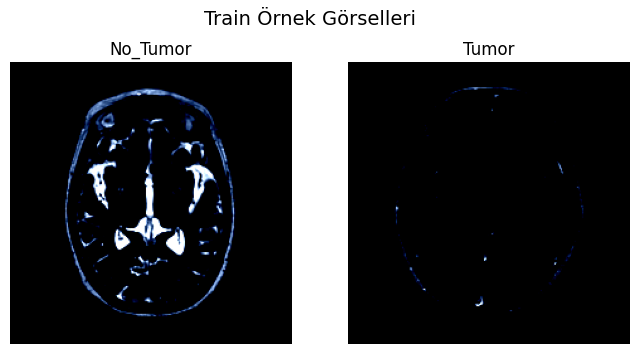

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/train_ornekler.png


,class_name,count,percentage (%)
0,No_Tumor,3311,50.0
1,Tumor,3311,50.0


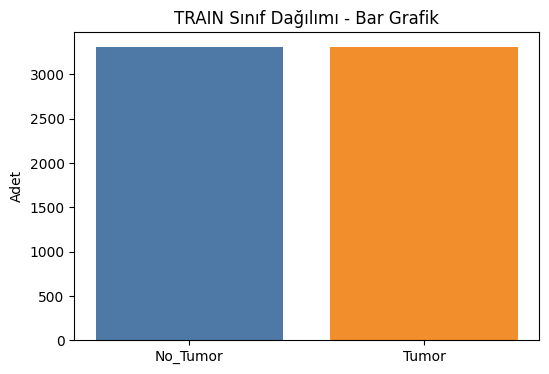

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/train_bar.png


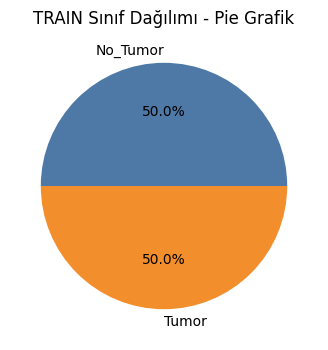

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/train_pie.png


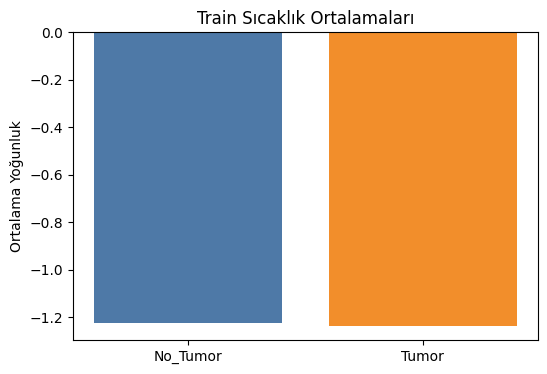

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/sicaklik_train.png


,class_name,mean_intensity,std
0,No_Tumor,-1.225452,0.337993
1,Tumor,-1.234923,0.226786


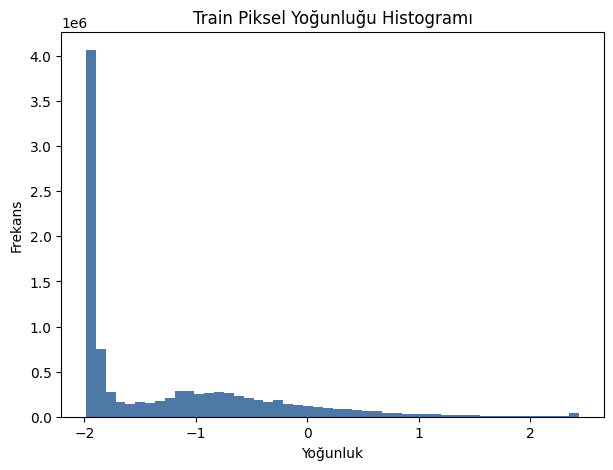

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/train_histogram.png


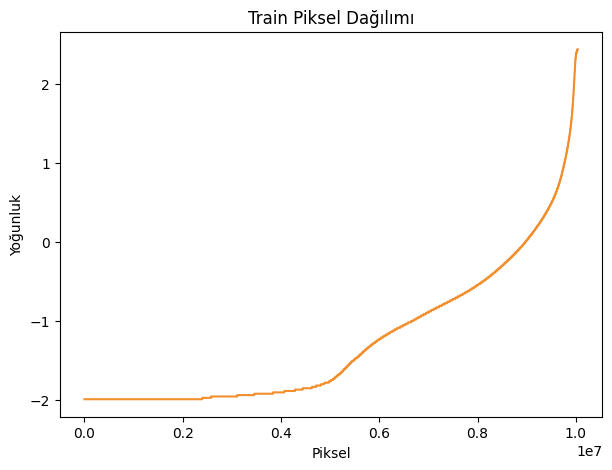

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/train_pixel_distribution.png

================ TEST EDA ================



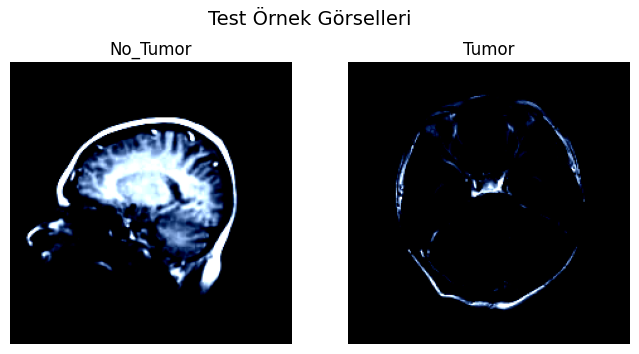

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/test_ornekler.png


,class_name,count,percentage (%)
0,No_Tumor,910,50.11
1,Tumor,906,49.89


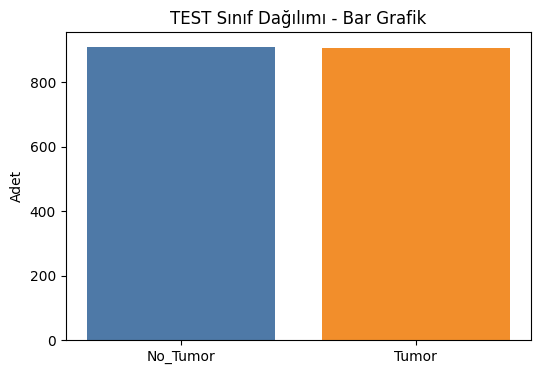

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/test_bar.png


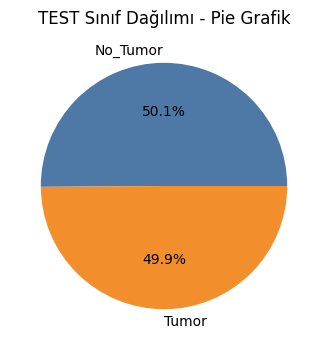

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/test_pie.png


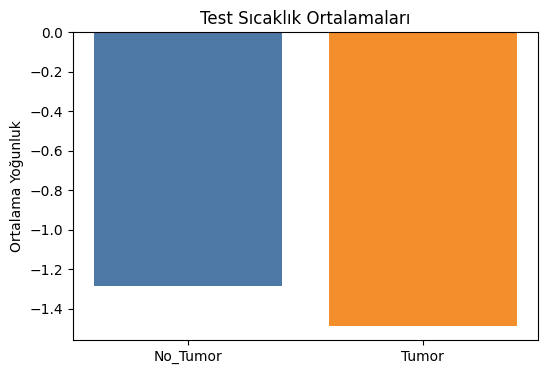

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/sicaklik_test.png


,class_name,mean_intensity,std
0,No_Tumor,-1.286103,0.167951
1,Tumor,-1.485626,0.113087


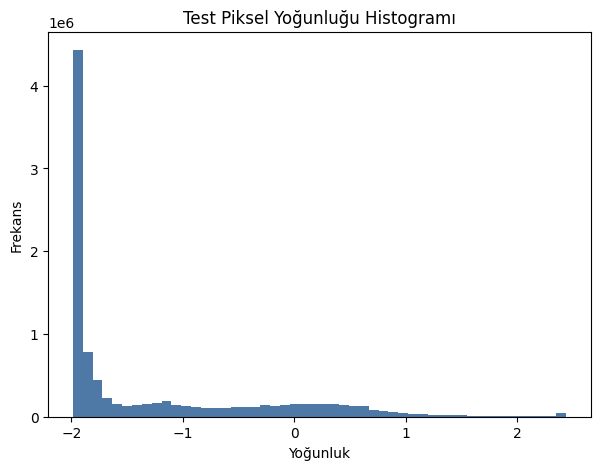

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/test_histogram.png


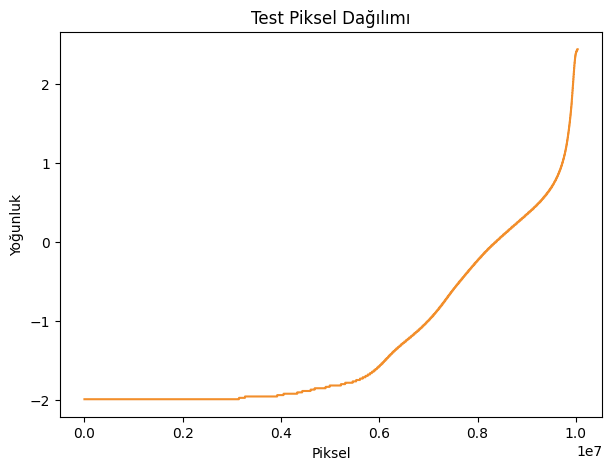

Kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/eda/test_pixel_distribution.png

🎉 EDA tamamlandı ve tüm grafikler başarıyla kaydedildi!


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

# =========================================================
# 0) DRIVE KAYIT KLASÖRLERİ
# =========================================================

drive_root = "/content/drive/MyDrive/Beyin Tümör Projesi"
eda_dir = os.path.join(drive_root, "eda")
os.makedirs(eda_dir, exist_ok=True)

print("Kayıt klasörü:", eda_dir)


# =========================================================
# 🔥 1) GERÇEK KLASÖR VERİ SAYIMI (Train/Test tam sayı)
# =========================================================

def count_images_in_folder(folder_path):
    counts = {}
    total = 0

    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)

        # klasör değilse geç
        if not os.path.isdir(cls_path):
            continue

        # Bu sınıftaki tüm resimleri say
        image_count = sum(
            1 for f in os.listdir(cls_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        )

        counts[cls] = image_count
        total += image_count

    counts["total"] = total
    return counts


def print_dataset_summary(train_dir, test_dir):
    print("\n========== 📌 DATASET SUMMARY ==========\n")

    # ---- TRAIN ----
    train_counts = count_images_in_folder(train_dir)
    print("📂 TRAIN FOLDER:")
    for cls, cnt in train_counts.items():
        print(f"   {cls}: {cnt}")
    print()

    # ---- TEST ----
    test_counts = count_images_in_folder(test_dir)
    print("📂 TEST FOLDER:")
    for cls, cnt in test_counts.items():
        print(f"   {cls}: {cnt}")
    print("\n========================================\n")


# Dataset özetini yazdır
print_dataset_summary(train_dir, test_dir)


# =========================================================
# 2) SUBSET UYUMLU BASE DATASET ERİŞİMİ
# =========================================================

def get_base(dataset):
    return dataset.dataset if hasattr(dataset, "dataset") else dataset # Eğer dataset Subset ise gerçek dataset’i döndür

def get_indices(dataset): # Eğer Subset ise indeksleri al, değilse tüm indeksleri döndür
    if hasattr(dataset, "indices"):
        return dataset.indices
    return list(range(len(dataset)))


# =========================================================
# 3) ÖRNEK GÖRSELLER
# =========================================================

def show_sample_images(dataset, title, save_name):
    base = get_base(dataset) # Gerçek dataset
    indices = get_indices(dataset)

    plt.figure(figsize=(8,4))
    class_seen = {} # Her sınıftan bir örnek tut

    for idx in indices:
        img, label = base[idx]
        cls = base.classes[label]
        if cls not in class_seen:
            class_seen[cls] = img
        if len(class_seen) == len(base.classes):
            break
    # Her sınıf için bir örnek görsel çiz
    for i, cls in enumerate(base.classes):
        plt.subplot(1, len(base.classes), i+1)
        plt.imshow(class_seen[cls].permute(1,2,0))
        plt.title(cls)
        plt.axis("off")

    plt.suptitle(title, fontsize=14)

    path = os.path.join(eda_dir, save_name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Kaydedildi:", path)


# =========================================================
# 4) SINIF DAĞILIMI (SUBSET UYUMLU)
# =========================================================

def compute_class_distribution(dataset):
    base = get_base(dataset)
    indices = get_indices(dataset)

    labels = [base[idx][1] for idx in indices] # Etiketleri topla
    unique, counts = np.unique(labels, return_counts=True)

    df = pd.DataFrame({ # DataFrame oluştur
        "class_name": [base.classes[i] for i in unique],
        "count": counts,
        "percentage (%)": np.round(counts / len(labels) * 100, 2)
    })

    return df


# =========================================================
# 5) BAR + PIE GRAFİKLERİ
# =========================================================

def plot_bar_and_pie(df, title, save_bar, save_pie):
    # BAR
    plt.figure(figsize=(6,4))
    plt.bar(df["class_name"], df["count"], color=["#4e79a7", "#f28e2b"])
    plt.title(title + " - Bar Grafik")
    plt.ylabel("Adet")
    bar_path = os.path.join(eda_dir, save_bar)
    plt.savefig(bar_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Kaydedildi:", bar_path)

    # PIE
    plt.figure(figsize=(6,4))
    plt.pie(df["count"], labels=df["class_name"], autopct="%1.1f%%",
            colors=["#4e79a7", "#f28e2b"])
    plt.title(title + " - Pie Grafik")
    pie_path = os.path.join(eda_dir, save_pie)
    plt.savefig(pie_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Kaydedildi:", pie_path)


# =========================================================
# 6) YOĞUNLUK HISTOGRAMI
# =========================================================

def plot_intensity_histogram(dataset, title, save_name, n_samples=200):
    base = get_base(dataset)
    indices = get_indices(dataset)
    indices = indices[:min(n_samples, len(indices))]

    intensities = []

    for idx in indices:
        img, _ = base[idx]
        img_np = img.numpy().mean(axis=0) # Gri-seviye ortalama
        intensities.extend(img_np.flatten())

    plt.figure(figsize=(7,5))
    plt.hist(intensities, bins=50, color="#4e79a7")
    plt.title(title)
    plt.xlabel("Yoğunluk")
    plt.ylabel("Frekans")

    path = os.path.join(eda_dir, save_name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Kaydedildi:", path)


# =========================================================
# 7) PIKSEL DAĞILIMI
# =========================================================

def plot_pixel_distribution(dataset, title, save_name, n_samples=200):
    base = get_base(dataset)
    indices = get_indices(dataset)
    indices = indices[:min(n_samples, len(indices))]

    intensities = []

    for idx in indices:
        img,_ = base[idx]
        img_np = img.numpy().mean(axis=0)
        intensities.extend(img_np.flatten())

    intensities = np.sort(np.array(intensities))

    plt.figure(figsize=(7,5))
    plt.plot(intensities, color="#f28e2b")
    plt.title(title)
    plt.xlabel("Piksel")
    plt.ylabel("Yoğunluk")

    path = os.path.join(eda_dir, save_name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Kaydedildi:", path)


# =========================================================
# 8) SINIF BAZLI YOĞUNLUK
# =========================================================

def compute_class_intensity_stats(dataset, save_name, title, n_samples_per_class=50):
    base = get_base(dataset)
    indices = get_indices(dataset)

    class_lists = {cls: [] for cls in base.classes}

    for idx in indices:
        img, label = base[idx]
        cls = base.classes[label]

        if len(class_lists[cls]) < n_samples_per_class:
            gray = img.numpy().mean(axis=0)
            class_lists[cls].append(gray.mean())

    df = pd.DataFrame([ # Sonuçları DataFrame'e aktar
        [cls, np.mean(vals), np.std(vals)]
        for cls, vals in class_lists.items()
    ], columns=["class_name","mean_intensity","std"])

    # Bar grafik
    plt.figure(figsize=(6,4))
    plt.bar(df["class_name"], df["mean_intensity"], color=["#4e79a7","#f28e2b"])
    plt.title(title)
    plt.ylabel("Ortalama Yoğunluk")

    path = os.path.join(eda_dir, save_name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Kaydedildi:", path)

    return df


# =========================================================
#                    EDA ÇIKTILARI
# =========================================================

print("\n================ TRAIN EDA ================\n")

show_sample_images(train_dataset, "Train Örnek Görselleri", "train_ornekler.png")

train_dist = compute_class_distribution(train_dataset)
display(train_dist)

plot_bar_and_pie(train_dist, "TRAIN Sınıf Dağılımı",
                 "train_bar.png", "train_pie.png")

display(compute_class_intensity_stats(train_dataset,
                                      "sicaklik_train.png",
                                      "Train Sıcaklık Ortalamaları"))

plot_intensity_histogram(train_dataset,
                         "Train Piksel Yoğunluğu Histogramı",
                         "train_histogram.png")

plot_pixel_distribution(train_dataset,
                        "Train Piksel Dağılımı",
                        "train_pixel_distribution.png")


print("\n================ TEST EDA ================\n")

show_sample_images(test_dataset, "Test Örnek Görselleri", "test_ornekler.png")

test_dist = compute_class_distribution(test_dataset)
display(test_dist)

plot_bar_and_pie(test_dist, "TEST Sınıf Dağılımı",
                 "test_bar.png", "test_pie.png")

display(compute_class_intensity_stats(test_dataset,
                                      "sicaklik_test.png",
                                      "Test Sıcaklık Ortalamaları"))

plot_intensity_histogram(test_dataset,
                         "Test Piksel Yoğunluğu Histogramı",
                         "test_histogram.png")

plot_pixel_distribution(test_dataset,
                        "Test Piksel Dağılımı",
                        "test_pixel_distribution.png")

print("\n🎉 EDA tamamlandı ve tüm grafikler başarıyla kaydedildi!")


***HÜCRE 6 — Train / Evaluate Fonksiyonları***

In [5]:
from IPython.display import clear_output

# ---- Training Monitor ----------
class TrainingMonitor:
    def __init__(self):
        self.train_loss = [] # Train loss geçmişi
        self.train_acc = [] # Train accuracy geçmişi
        self.val_loss = [] # Validation loss geçmişi
        self.val_acc = [] # Validation accuracy geçmişi

    def update(self, tr_l, tr_a, val_l, val_a):
      # Her epoch sonunda metrikleri listeye ekle
        self.train_loss.append(tr_l)
        self.train_acc.append(tr_a)
        self.val_loss.append(val_l)
        self.val_acc.append(val_a)
        self.plot()  # Güncel grafikleri çiz

    def plot(self):
        clear_output(wait=True) # Önceki çıktıyı temizle
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1) # Loss grafiği
        plt.plot(self.train_loss, label="Train Loss")
        plt.plot(self.val_loss, label="Val Loss")
        plt.legend()
        plt.title("Loss")

        plt.subplot(1,2,2) # Accuracy grafiği
        plt.plot(self.train_acc, label="Train Acc")
        plt.plot(self.val_acc, label="Val Acc")
        plt.legend()
        plt.title("Accuracy")

        plt.show()


# ---- TRAIN ONE EPOCH ----------
def train_one_epoch(model, loader, criterion, optimizer):
    model.train() # Modeli train moduna al
    t_loss, t_acc, total = 0, 0, 0 # Toplam loss, accuracy ve örnek sayısı

    for x, y in loader:
        x, y = x.to(device), y.to(device) # Veriyi GPU/CPU'ya taşı
        optimizer.zero_grad() # Gradients sıfırla

        out = model(x) # Forward pass
        loss = criterion(out, y) # Loss hesapla

        loss.backward() # Backpropagation
        optimizer.step() # Ağırlıkları güncelle

        t_loss += loss.item() * x.size(0) # Batch loss ekle
        t_acc  += (out.argmax(1) == y).sum().item() # Doğru tahmin sayısı
        total  += x.size(0) # Toplam örnek sayısı

    return t_loss / total, t_acc / total # Ortalama loss ve accuracy


# ---- EVALUATE ----------
def evaluate(model, loader, criterion, return_details=False):
    model.eval() # Modeli evaluation moduna al
    t_loss, t_acc, total = 0, 0, 0

    y_true, y_prob, y_pred = [], [], [] # Detaylı metrikler için listeler

    with torch.no_grad(): # Gradient hesaplama kapalı
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            t_loss += loss.item() * x.size(0)
            t_acc  += (out.argmax(1) == y).sum().item()
            total  += x.size(0)

            if return_details:
                probs = torch.softmax(out,1)[:,1] # Pozitif sınıf olasılığı
                y_true.extend(y.cpu().numpy()) # Gerçek etiketler
                y_pred.extend(out.argmax(1).cpu().numpy()) # Tahminler
                y_prob.extend(probs.cpu().numpy()) # Olasılıklar

    if return_details:
        return (
            t_loss / total,
            t_acc / total,
            np.array(y_true),
            np.array(y_prob),
            np.array(y_pred)
        )
    else:
        return t_loss / total, t_acc / total


# ---- TRAIN MODEL ----------
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, cfg, name):

    monitor = TrainingMonitor() # Eğitim monitörü

    epochs = cfg["epochs"] # Toplam epoch sayısı
    warmup_epochs = cfg.get("warmup_epochs", 2) # Warmup epoch
    patience = cfg.get("early_stop", 5) # Early stopping sabrı

    # Cosine Annealing learning rate scheduler
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs - warmup_epochs
    )

    # Validation loss’a göre LR düşüren scheduler
    reduce_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=2
    )

    best_loss = float("inf") # En iyi validation loss
    best_state = None # En iyi model ağırlıkları
    no_improve = 0 # İyileşme sayacı

    for epoch in range(1, epochs + 1):

        # --- WARMUP ---
        if epoch <= warmup_epochs:
            for g in optimizer.param_groups:
                g["lr"] = cfg["lr"] * epoch / warmup_epochs

        # Train ve validation adımları
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Scheduler güncellemeleri
        if epoch > warmup_epochs:
            cosine_scheduler.step()
        reduce_scheduler.step(val_loss)

        monitor.update(tr_loss, tr_acc, val_loss, val_acc) # Canlı grafik güncelle

        print(f"{name} | Epoch {epoch}/{epochs} | " # Epoch çıktısı
              f"Train {tr_loss:.4f}/{tr_acc:.4f} | "
              f"Val {val_loss:.4f}/{val_acc:.4f}")

        if val_loss < best_loss: # En iyi model kontrolü
            best_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("\n EARLY STOPPING!")
                break

    # En iyi modeli yükle
    model.load_state_dict(best_state)

    # --- FINAL TEST ---
    test_loss, test_acc, y_true, y_prob, y_pred = evaluate(
        model, test_loader, criterion, return_details=True
    )

    print(f"\n📌 TEST → Loss={test_loss:.4f}, Acc={test_acc:.4f}")

    return model, monitor, y_true, y_prob, y_pred, test_loss, test_acc


***HÜCRE 7 — Selective Hybrid Config File***

In [6]:
# ============================================================
# HYBRID_CONFIG — HİBRİT CNN MİMARİ KONFİGÜRASYONLARI
# ============================================================
# Bu sözlük, çalışmada kullanılan hibrit derin öğrenme modellerinin
# mimari yapılarını tanımlamak için oluşturulmuştur.
#
# Her bir hibrit model iki farklı backbone (ön-eğitimli CNN) kullanır.
# Belirlenen ara katmanlardan (layers) özellik haritaları çıkarılır
# ve seçilen fusion (özellik birleştirme) yöntemi ile bir araya getirilir.
#
# Parametre Açıklamaları:
# - backbone1 / backbone2 : Kullanılan CNN mimarileri
# - layers1 / layers2     : Özellik çıkarımı yapılacak ara katmanlar
# - fusion                : Özellik birleştirme yöntemi
#                            ("concat", "add", "weighted")
# - projection_dim        : Birleştirme sonrası projeksiyon boyutu
#                           (tam bağlantılı katmana giriş boyutu)
#
# Bu yapı sayesinde farklı mimarilerin güçlü yönleri
# tek bir model altında birleştirilebilmektedir.
# ============================================================
HYBRID_CONFIG = {

    "VGG16_VGG19": {
        "backbone1": "vgg16", # Birinci backbone
        "layers1": ["3", "8"], # VGG16 ara katmanları
        "backbone2": "vgg19", # İkinci backbone
        "layers2": ["12"], # VGG19 ara katmanı
        "fusion": "concat",# Özellikleri birleştir (concatenation)
        "projection_dim": 512 # Projeksiyon katmanı boyutu
    },

    "VGG19_ResNet50": {
        "backbone1": "vgg19",
        "layers1": ["5", "10"],
        "backbone2": "resnet50",
        "layers2": ["2", "4"],
        "fusion": "weighted", # Ağırlıklı özellik birleştirme
        "projection_dim": 1024
    },

    "ResNet50_DenseNet121": {
        "backbone1": "resnet50",
        "layers1": ["3"],
        "backbone2": "densenet121",
        "layers2": ["transition2"],
        "fusion": "concat",
        "projection_dim": 1024
    },

    "ResNet101_VGG16": {
        "backbone1": "resnet101",
        "layers1": ["2", "4"],
        "backbone2": "vgg16",
        "layers2": ["10"],
        "fusion": "add", # Özellikleri toplama ile birleştir
        "projection_dim": 512
    },

    "DenseNet121_EfficientNetB0": {
        "backbone1": "densenet121",
        "layers1": ["transition1"],
        "backbone2": "efficientnetb0",
        "layers2": ["4"],
        "fusion": "concat",
        "projection_dim": 1024
    },

    "EfficientNetB0_ResNet50": {
        "backbone1": "efficientnetb0",
        "layers1": ["6"],
        "backbone2": "resnet50",
        "layers2": ["4"],
        "fusion": "weighted",
        "projection_dim": 2048
    },

    "EfficientNetB3_ResNet101": {
        "backbone1": "efficientnetb3",
        "layers1": ["6"],
        "backbone2": "resnet101",
        "layers2": ["4"],
        "fusion": "concat",
        "projection_dim": 2048
    },

    "MobileNetV2_EfficientNetB3": {
        "backbone1": "mobilenetv2",
        "layers1": ["7"],
        "backbone2": "efficientnetb3",
        "layers2": ["4"],
        "fusion": "concat",
        "projection_dim": 1024
    },

    "VGG16_EfficientNetB0": {
        "backbone1": "vgg16",
        "layers1": ["5"],
        "backbone2": "efficientnetb0",
        "layers2": ["6"],
        "fusion": "add",
        "projection_dim": 512
    }
}


***HÜCRE 8 — Selective Backbone + Hybrid Model***

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ------------------------------------------------------------
# 1) BACKBONE GETİRME FONKSİYONU
# ------------------------------------------------------------
# İstenen backbone adına göre ImageNet pretrained modeli yükler
# ve feature extraction kısmını döndürür
def get_backbone(name):
    if name == "vgg16":
        m = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        return m.features # VGG feature katmanları

    elif name == "vgg19":
        m = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        return m.features

    elif name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        # ResNet feature extractor (fc hariç)
        return nn.Sequential(
            m.conv1, m.bn1, m.relu, m.maxpool,
            m.layer1, m.layer2, m.layer3, m.layer4
        )

    elif name == "resnet101":
        m = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
        return nn.Sequential(
            m.conv1, m.bn1, m.relu, m.maxpool,
            m.layer1, m.layer2, m.layer3, m.layer4
        )

    elif name == "densenet121":
        m = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        return m.features

    elif name == "efficientnetb0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        return m.features

    elif name == "efficientnetb3":
        m = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        return m.features

    elif name == "mobilenetv2":
        m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        return m.features

    else:
        raise ValueError(f"Unknown backbone name: {name}")


# ------------------------------------------------------------
# 2) PICKLE UYUMLU HOOK SINIFI
# ------------------------------------------------------------
# Ara katman çıktısını yakalamak için kullanılan hook
# Lambda/closure içermediği için pickle ile uyumludur
class ForwardHook:
    """
    Pickle-friendly forward hook.
    closure / lambda YOK → sorunsuz kaydedilir.
    """
    def __init__(self, owner, layer_name):
        self.owner = owner # SelectiveBackbone referansı
        self.layer_name = layer_name # Katman adı

    def __call__(self, module, inp, out):
        # Forward sırasında ilgili katman çıktısını kaydet
        self.owner.outputs[self.layer_name] = out


# ------------------------------------------------------------
# 3) Selective Backbone (Ara Katman Çıkışı İçin)
# ------------------------------------------------------------

class SelectiveBackbone(nn.Module):
    def __init__(self, backbone, selected_layers):
        super().__init__()
        self.backbone = backbone # CNN backbone
        self.selected_layers = selected_layers
        self.outputs = {}

        self._hooks = [] # Hook çıktıları

        # Belirlenen katmanlara forward hook ekle
        for layer_name in selected_layers:
            layer = self.get_layer_by_name(backbone, layer_name)
            hook_fn = ForwardHook(self, layer_name)
            h = layer.register_forward_hook(hook_fn)
            self._hooks.append(h)

        self.pool = nn.AdaptiveAvgPool2d((1,1)) # Global pooling

    def get_layer_by_name(self, model, name):
        """
        - Sequential modeller için: index ("3", "8" vb.)
        - ResNet gibi modeller için: attribute adı ("layer2", "layer4")
        """
        if name.isdigit():
            return model[int(name)]

        if hasattr(model, name):
            return getattr(model, name)

        raise ValueError(f"Layer bulunamadı: {name}")

    def forward(self, x):
        self.outputs = {} # Önceki çıktıları temizle
        _ = self.backbone(x)   # Forward → hook’lar tetiklenir

        pooled = []
        for lname in self.selected_layers:
            f = self.outputs[lname]# İlgili katman çıktısı
            f = self.pool(f)# AdaptiveAvgPool
            f = torch.flatten(f, 1)
            pooled.append(f)

        return torch.cat(pooled, dim=1)# Tüm seçili katmanları birleştir


# ------------------------------------------------------------
# 4) Selective Hybrid Model
# ------------------------------------------------------------

class SelectiveHybridModel(nn.Module):
    def __init__(self, config, num_classes=2):
        super().__init__()

        self.config = config

        # İki ayrı selective backbone
        self.sb1 = SelectiveBackbone(
            get_backbone(config["backbone1"]),
            config["layers1"]
        )
        self.sb2 = SelectiveBackbone(
            get_backbone(config["backbone2"]),
            config["layers2"]
        )

        self.proj_dim = config["projection_dim"] # Ortak feature boyutu
        self.fusion_type = config["fusion"] # Fusion yöntemi

        # Backbone çıkışlarını aynı boyuta projekte eden katmanlar
        self.proj1 = nn.LazyLinear(self.proj_dim)
        self.proj2 = nn.LazyLinear(self.proj_dim)

        # Fusion tipine göre classifier giriş boyutu
        fusion_dim = self.proj_dim * 2 if self.fusion_type == "concat" else self.proj_dim

        # Sınıflandırıcı katman
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def fusion(self, f1, f2):
        if self.fusion_type == "concat":
            return torch.cat([f1, f2], dim=1)
        elif self.fusion_type == "add":
            return f1 + f2
        elif self.fusion_type == "weighted":
            return 0.6*f1 + 0.4*f2
        else:
            raise ValueError("Unknown fusion type")

    def forward(self, x):
      # İki backbone’dan özellik çıkar
        f1 = self.sb1(x)
        f2 = self.sb2(x)

        # Ortak boyuta projekte et

        f1 = self.proj1(f1)
        f2 = self.proj2(f2)

        # Fusion + sınıflandırma
        fused = self.fusion(f1, f2)
        return self.classifier(fused)


***HÜCRE 9 — Özgün Model: KiliCNN***

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------------------------------
# Depthwise Separable Convolution (Senin temel bloğun)
# --------------------------------------------------
# Amaç: Parametre sayısını ve hesaplama maliyetini azaltmak
# Depthwise: Her kanal için ayrı filtre
# Pointwise: Kanallar arası bilgi karışımı (1x1 conv)
class SeparableConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, stride=1, padding=1):
        super().__init__()
        # Depthwise: her kanal için ayrı filtre
        self.dw = nn.Conv2d(
            in_c, in_c,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_c, # Kanal başına filtre
            bias=False
        )
        # Pointwise: kanalları karıştıran 1x1 conv
        self.pw = nn.Conv2d(in_c, out_c, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.dw(x)# Kanal bazlı uzamsal filtreleme
        x = self.pw(x) # Kanal birleştirme
        return x


# --------------------------------------------------
# SE (Squeeze & Excitation) Attention Bloğu
# --------------------------------------------------
# Amaç: Kanal bazlı dikkat (channel attention) mekanizması
class SEBlock(nn.Module):
    def __init__(self, channels, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1) # Global average pooling
        # Kanal ağırlıklarını öğrenen tam bağlantılı katmanlar
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // r),
            nn.ReLU(inplace=True),
            nn.Linear(channels // r, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)      # [B, C, 1, 1] -> [B, C]
        w = self.fc(w).view(b, c, 1, 1)  # tekrar uzat
        return x * w                     # kanal bazlı ağırlık


# --------------------------------------------------
# Geliştirilmiş Residual Blok (Separable + SE + SiLU)
# --------------------------------------------------
# İçerik:
# - Depthwise separable conv
# - BatchNorm
# - SE attention
# - SiLU aktivasyon
# - Dropout + residual bağlantı
class ResidualKilic(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        # Conv1
        self.conv1 = SeparableConv2d(in_c, out_c)
        self.bn1   = nn.BatchNorm2d(out_c)

        # Conv2
        self.conv2 = SeparableConv2d(out_c, out_c)
        self.bn2   = nn.BatchNorm2d(out_c)

        # SE Block
        self.se    = SEBlock(out_c, r=8)

         # Feature-level dropout
        self.dropout = nn.Dropout2d(0.1)

        # Residual bağlantı için stochastic depth benzeri dropout
        self.resdrop = nn.Dropout(0.05)

        # Kanal sayısı değişiyorsa identity uyarlama
        if in_c != out_c:
            self.down = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.down = None

        self.act = nn.SiLU() # SiLU / Swish aktivasyonu

    def forward(self, x):
        identity = x

         # Conv 1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        # Conv 2
        out = self.conv2(out)
        out = self.bn2(out)

        # SE
        out = self.se(out)

        # Dropout2D
        out = self.dropout(out)

        # Identity downsample (gerekirse)
        if self.down is not None:
            identity = self.down(identity)

        # Residual dropout
        identity = self.resdrop(identity)

        # Residual toplama
        out = out + identity
        out = self.act(out)

        return out


# --------------------------------------------------
# Geliştirilmiş Özgün Model: KilicNN
# --------------------------------------------------
# Yapı:
# - Stem (erken downsampling)
# - 3 adet ResidualKilic blok
# - Global average pooling
# - Fully connected classifier
class KilicNN(nn.Module):

    def __init__(self, num_classes=2):
        super().__init__()

        # Stem: girişte biraz daha geniş kanal
        self.stem = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.SiLU(),
            nn.AvgPool2d(2)
        )

        # Residual katmanlar (kanal sayısını artırıyoruz)
        self.layer1 = ResidualKilic(48, 96)
        self.layer2 = ResidualKilic(96, 192)
        self.layer3 = ResidualKilic(192, 256)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.ln = nn.LayerNorm(256)
        # Fully connected kısım
        self.fc = nn.Sequential(
            self.ln,
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)            # Giriş stem
        x = self.layer1(x)          # Residual blok 1
        x = self.layer2(x)          # Residual blok 2
        x = self.layer3(x)          # Residual blok 3
        x = self.pool(x)            # Global pooling
        x = torch.flatten(x, 1)     # [B, 256]
        x = self.fc(x)              # Sınıflandırma
        return x

***HÜCRE 10 — Tüm Hibrit Modelleri OLUŞTURAN FONKSİYON***

In [9]:
def build_hybrid(name):
    """
    Hibrit modeli HYBRID_CONFIG üzerinden kurar.
    ilgili selektif hibrit modeli oluşturur.
    """
    if name not in HYBRID_CONFIG: # İstenen hibrit model konfigürasyonunun varlığını kontrol eder
        raise ValueError(f"Hibrit model bulunamadı: {name}")

    config = HYBRID_CONFIG[name] # Seçilen modele ait konfigürasyonu al
    model = SelectiveHybridModel(config, num_classes=2) # Hibrit modeli oluştur
    return model # Oluşturulan modeli döndür

***HÜCRE 11 — Tüm Model Konfigürasyonları***

In [10]:
MODEL_CONFIG = {
# Bu sözlük, çalışmada kullanılan tüm modellerin
# eğitim (training) hiperparametrelerini merkezi
# ve düzenli bir şekilde tanımlamak için oluşturulmuştur.
#
# Her model için:
# - Model tipi (hybrid / custom)
# - Öğrenme oranı (lr)
# - Epoch sayısı
# - Batch size
# - Optimizer ve scheduler türü
# - Regularization ve early stopping ayarları
# - Görüntü boyutu ve loss fonksiyonu
# açıkça belirtilmiştir.

    # --------------------------------------
    # HİBRİT MODELLER
    # --------------------------------------

    "VGG16_VGG19": {
        "type": "hybrid", # Model türü (hibrit CNN)
        "lr": 1e-4, # Başlangıç learning rate
        "epochs": 15, # Toplam epoch sayısı
        "batch_size": 128, # Batch size
        "optimizer": "adamw", # Optimizer tipi
        "weight_decay": 1e-4, # L2 regularization
        "scheduler": "cosine", # Cosine annealing scheduler
        "warmup_epochs": 2, # Learning rate warmup
        "early_stop": 5, # Early stopping sabrı
        "img_size": 224, # Giriş görüntü boyutu
        "loss": "crossentropy" # Loss fonksiyonu
    },

    "VGG19_ResNet50": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "ResNet50_DenseNet121": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "ResNet101_VGG16": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "DenseNet121_EfficientNetB0": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 32,  # Daha büyük model → daha küçük batch
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "EfficientNetB0_ResNet50": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "EfficientNetB3_ResNet101": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "MobileNetV2_EfficientNetB3": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    "VGG16_EfficientNetB0": {
        "type": "hybrid",
        "lr": 1e-4,
        "epochs": 15,
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "warmup_epochs": 2,
        "early_stop": 5,
        "img_size": 224,
        "loss": "crossentropy"
    },

    # --------------------------------------
    # ÖZGÜN MODEL (KİLICNN)
    # --------------------------------------

    "KilicNN": {
        "type": "custom", # özgün mimari
        "lr": 1e-3, # Daha agresif learning rate
        "epochs": 30, # Daha uzun eğitim
        "batch_size": 128,
        "optimizer": "adamw",
        "weight_decay": 1e-4,
        "scheduler": "onecycle",  # OneCycleLR scheduler
        "max_lr": 2e-3, # OneCycle için maksimum lr
        "early_stop": 8,
        "warmup_epochs": 2,
        "img_size": 224,
        "loss": "crossentropy"
    }
}

***HÜCRE 12_13 — Model Çalıştırma Fonksiyonu + Model Seçimi***

In [11]:
from ipywidgets import Dropdown, Button, VBox, Output # Etkileşimli arayüz bileşenleri
from IPython.display import display, clear_output # Notebook içi çıktı kontrolü

# MODEL_CONFIG içinde tanımlı tüm modeller otomatik alınır
model_list = list(MODEL_CONFIG.keys())

# Dropdown
model_selector = Dropdown(
    options=model_list, # Seçilebilir model isimleri
    value=model_list[0],# Varsayılan seçili model
    description='Model:', # Etiket
    disabled=False # Kullanıcı etkileşimine açık
)

# Seçim butonu
select_button = Button(
    description='MODELİ SEÇ', # Buton üzerindeki yazı
    button_style='info',  # Görsel stil
    tooltip='Bu model bir sonraki hücrede eğitilecek'
)

# Çıktı alanı
output_area = Output() # Seçim sonrası mesajların gösterileceği alan

# Global değişken
selected_model = None # Seçilen model adı burada tutulur

# Buton event
def on_select(b):
    global selected_model
    selected_model = model_selector.value  # Dropdown'dan seçilen modeli al
    with output_area:
        clear_output() # Önceki çıktıları temizle
        print(f"Seçilen model: {selected_model}")
        print("Bir sonraki hücrede eğitim başlatabilirsiniz:"
              "   run_model(selected_model)")

select_button.on_click(on_select) # Butona tıklama olayını bağla

# Arayüzü göster
display(VBox([model_selector, select_button, output_area]))


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score,
    cohen_kappa_score
)

results = []   # tüm modellerin özet sonuçları burada birikecek


def run_model(name):
    cfg = MODEL_CONFIG[name] # Seçilen modele ait konfigürasyonu al

    print(f"\n================ {name} ================\n")
    print("Konfig:", cfg)

    # -------------------------------
    # Model seçimi
    # -------------------------------
    if cfg["type"] == "hybrid":
        model = build_hybrid(name)# Hibrit model
    else:
        model = KilicNN() # Özgün KilicNN modeli

    model = model.to(device) # Modeli GPU/CPU'ya taşı

    # Loss
    class_weights = torch.tensor([1.0, 1.05]).to(device) # Sınıf dengesizliği için ağırlıklı CrossEntropy
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg.get("weight_decay", 1e-4)
    )

    # -------------------------------
    # Training → train_model BEST MODEL döndürüyor
    # -------------------------------
    best_model, monitor, y_true, y_prob, y_pred, best_test_loss, best_test_acc = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        criterion,
        optimizer,
        cfg,
        name
    )

    print("\n🔥 EN İYİ MODEL test_acc:", best_test_acc)

    # -------------------------------
    # METRİKLER (TEST SETİ)
    # -------------------------------
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / (tp + tn + fp + fn)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1  = f1_score(y_true, y_pred, zero_division=0)
    kap = cohen_kappa_score(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # -------------------------------
    # RESULT TABLOSU
    # -------------------------------
    results.append({
        "model": name,
        "accuracy": acc,
        "precision": pre,
        "recall": rec,
        "specificity": spe,
        "f1": f1,
        "kappa": kap,
        "auc": roc_auc,
        "test_loss": best_test_loss,
        "train_loss": monitor.train_loss,
        "train_acc": monitor.train_acc,
        "val_loss": monitor.val_loss,
        "val_acc": monitor.val_acc
    })

    # -------------------------------
    # KAYIT KLASÖRLERİ
    # -------------------------------
    base_dir = "/content/drive/MyDrive/Beyin Tümör Projesi"
    model_root = os.path.join(base_dir, "modeller2")
    os.makedirs(model_root, exist_ok=True)

    model_dir = os.path.join(model_root, name)
    os.makedirs(model_dir, exist_ok=True)

    # -------------------------------
    #  EN İYİ MODELİ KAYDET (GARANTİ)
    # -------------------------------
    best_model_path = os.path.join(model_dir, f"{name}_best2.pt")
    torch.save(best_model.state_dict(), best_model_path)
    print("💾 EN İYİ MODEL state_dict olarak kaydedildi:", best_model_path)

    # -------------------------------
    #  TorchScript EXPORT (BEST MODEL)
    # -------------------------------
    try:
        best_cpu = best_model.to("cpu").eval()
        example = torch.randn(1, 3, 224, 224)

        scripted = torch.jit.trace(best_cpu, example)
        ts_path = os.path.join(model_dir, f"{name}_scripted2.pt")
        scripted.save(ts_path)

        print("TorchScript BEST MODEL kaydedildi:", ts_path)

    except Exception as e:
        print("TorchScript export hatası:", e)

    # Device'a geri al
    best_model = best_model.to(device)

    # -------------------------------
    # CONFUSION MATRIX PNG
    # -------------------------------
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.colorbar()

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    cm_path = os.path.join(model_dir, "confusion_matrix2.png")
    plt.savefig(cm_path, dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------
    # ROC PNG
    # -------------------------------
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.legend()
    roc_path = os.path.join(model_dir, "roc_curve2.png")
    plt.savefig(roc_path, dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------
    # Accuracy Curve
    # -------------------------------
    epochs = range(1, len(monitor.train_acc) + 1)

    plt.figure(figsize=(5, 4))
    plt.plot(epochs, monitor.train_acc, label="Train Acc")
    plt.plot(epochs, monitor.val_acc, label="Val Acc")
    plt.legend()
    acc_curve_path = os.path.join(model_dir, "accuracy_curve2.png")
    plt.savefig(acc_curve_path, dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------
    # Loss Curve
    # -------------------------------
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, monitor.train_loss, label="Train Loss")
    plt.plot(epochs, monitor.val_loss, label="Val Loss")
    plt.legend()
    loss_curve_path = os.path.join(model_dir, "loss_curve2.png")
    plt.savefig(loss_curve_path, dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------
    # METRİK TABLOSU PNG
    # -------------------------------
    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "Specificity",
                   "F1 Score", "Kappa", "AUC"],
        "Value": [acc, pre, rec, spe, f1, kap, roc_auc]
    })

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axis('off')

    tbl = ax.table(
        cellText=np.round(metrics_df["Value"].values, 4).reshape(-1,1),
        rowLabels=metrics_df["Metric"],
        colLabels=["Value"],
        loc="center",
        cellLoc="center"
    )

    tbl.scale(1, 1.4)

    metrics_png = os.path.join(model_dir, "metrics_table2.png")
    plt.savefig(metrics_png, dpi=300, bbox_inches="tight")
    plt.show()

    print("METRİK TABLOSU kaydedildi:", metrics_png)

    return best_model

***HÜCRE 14 — Bir Modeli Çalıştırma***

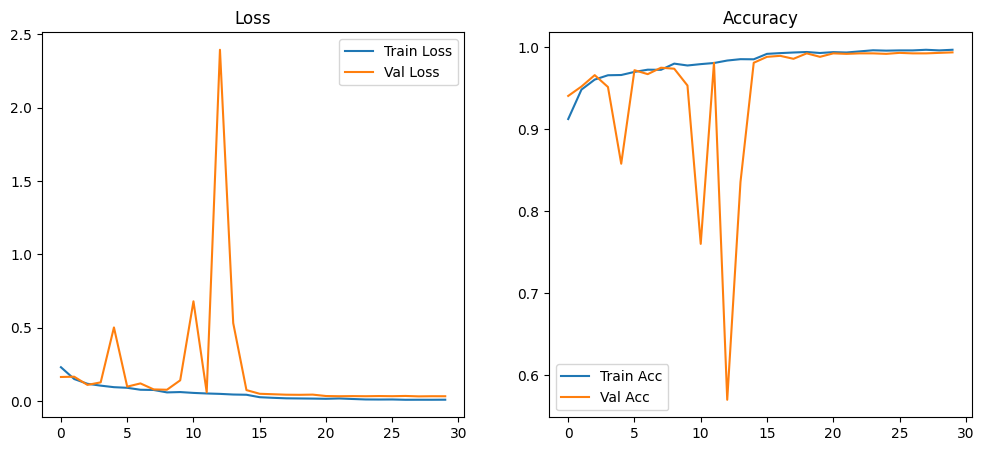

KilicNN | Epoch 30/30 | Train 0.0099/0.9971 | Val 0.0335/0.9940

📌 TEST → Loss=0.0345, Acc=0.9917

🔥 EN İYİ MODEL test_acc: 0.9917400881057269
💾 EN İYİ MODEL state_dict olarak kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/modeller2/KilicNN/KilicNN_best2.pt
🔥 TorchScript BEST MODEL kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/modeller2/KilicNN/KilicNN_scripted2.pt


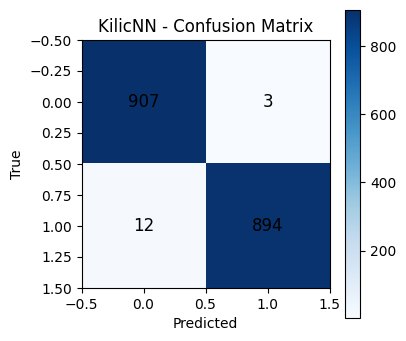

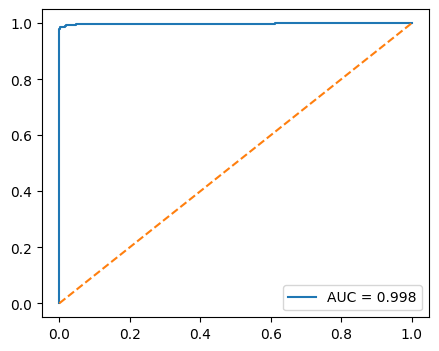

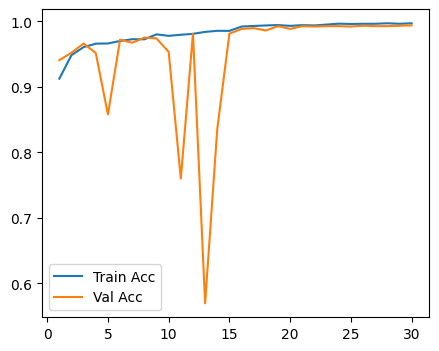

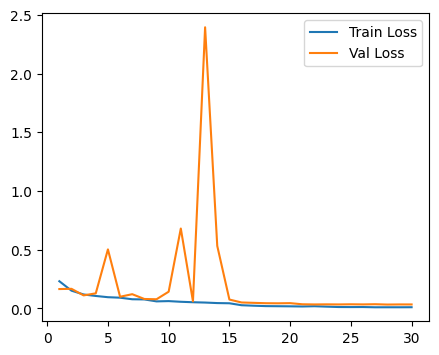

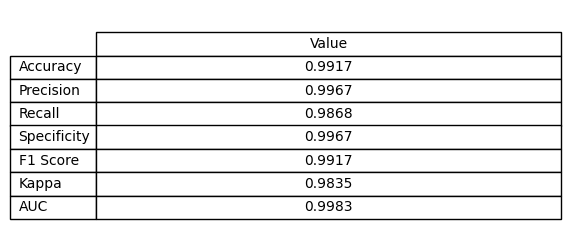

📊 METRİK TABLOSU kaydedildi: /content/drive/MyDrive/Beyin Tümör Projesi/modeller2/KilicNN/metrics_table2.png


In [ ]:
# Önceki hücrede (Model Seçim Arayüzü) kullanıcı tarafından seçilen model adı `selected_model` değişkeninde tutulur. Model çalıştırılır.
model = run_model(selected_model)

Accuracy: 0.9866666666666667
Precision: 0.9988610478359908
Recall: 0.9744444444444444
F1 Score: 0.9865016872890888

Confusion Matrix:
 [[899   1]
 [ 23 877]]


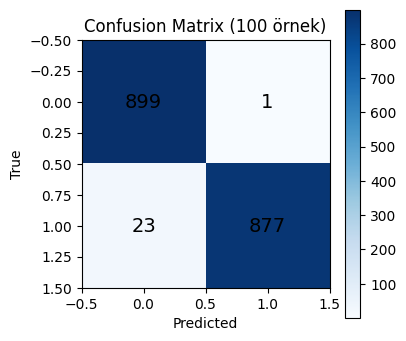

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ------------------------------------------
# 1) TorchScript Modeli Yükle
# ------------------------------------------
model_path = "/content/drive/MyDrive/Beyin Tümör Projesi/modeller/KilicNN/KilicNN_scripted.pt"
model = torch.jit.load(model_path, map_location="cpu")
model.eval()

class_names = ["No_Tumor", "Tumor"]

# ------------------------------------------
# 2) Transform (Aynı olmalı!)
# ------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ------------------------------------------
# 3) Test için her sınıftan 50 görsel seç
# ------------------------------------------
test_dir = "/content/drive/MyDrive/BrainTumorDataset/test"

no_tumor_dir = os.path.join(test_dir, "No_Tumor")
tumor_dir    = os.path.join(test_dir, "Tumor")

no_tumor_imgs = sorted(os.listdir(no_tumor_dir))[:900]
tumor_imgs    = sorted(os.listdir(tumor_dir))[:900]

image_paths = (
    [os.path.join(no_tumor_dir, img) for img in no_tumor_imgs] +
    [os.path.join(tumor_dir, img) for img in tumor_imgs]
)

y_true = np.array([0]*900 + [1]*900)   # 0 = No_Tumor, 1 = Tumor
y_pred = []

# ------------------------------------------
# 4) Tahmin döngüsü
# ------------------------------------------
for path in image_paths:
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        out = model(img_tensor)
        pred = torch.argmax(out, dim=1).item()

    y_pred.append(pred)

y_pred = np.array(y_pred)

# ------------------------------------------
# 5) METRİKLERİ HESAPLA
# ------------------------------------------
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("\nConfusion Matrix:\n", cm)

# ------------------------------------------
# 6) CONFUSION MATRIX GÖRSELİ
# ------------------------------------------
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (100 örnek)")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()